# Analyzer

Analyzer is a python program that tries to gauge the maintainability of java software. To achieve this, it tries to measure the complxity of the software under evalutation. As the Wikipedia article (https://en.wikipedia.org/wiki/Programming_complexity) on programming complexity states : 

As the number of entities increases, the number of interactions between them would increase exponentially, and it would get to a point where it would be impossible to know and understand all of them. Similarly, higher levels of complexity in software increase the risk of unintentionally interfering with interactions and so increases the chance of introducing defects when making changes. In more extreme cases, it can make modifying the software virtually impossible.

Analyzer tries to measure that complexity by taking several factors into account :
1. Commit frequency. This can find the 'hotspots' in code where many changes were performed and which can be problem zones. This idea was proposed by Adam Tornhill in 'Your Code as a Crime Scene'.
2. Class reference count. This metric measures the degree of coupling betweem classes by counting the references to them.
3. Inheritance count. This is a measure of the coupling that exists because of inheritance.
4. Lines of code. A rather crude metric that tries to measure the length of our software system.
5. Number of methods. This is a measure of the complexity of the system.
6. Halstead complexity measures : https://en.wikipedia.org/wiki/Halstead_complexity_measures

To add to these metrics, we propose to use the metrics as proposed by Sanjay Misra en Ferid Cafer in their paper 'ESTIMATING COMPLEXITY OF PROGRAMS IN PYTHON LANGUAGE'.
To quote from this paper :

Complexity of a system depends on the following factors  :
1. Complexity due to classes. Class is a basic unit of object oriented software development. All the functions are distributed in different classes. Further classes in the object-oriented code either are in inheritance hierarchy or distinctly distributed. Accordingly, the complexity of all the classes is due to classes in inheritance hierarchy and the complexity of distinct classes.
2. Complexity due to global factors: The second important factor, which is normally neglected in calculating complexity of object-oriented codes, is the complexity of global factors in main program.
3. Complexity due to coupling: Coupling is one of the important factors for increasing complexity of object- oriented code.

The aim of this chapter is to discover trends in news articles by clustering, or grouping, them together. To do that, we will use the k-means algorithm, a classic machine-learning algorithm originally developed in 1957.
Clustering is an unsupervised learning technique and we use clustering algorithms for exploring data. Our dataset contains approximately 500 stories, and it would
be quite arduous to examine each of those stories individually. Even if we
used summary statistics, that is still a lot of data. Using clustering allows us to group similar stories together, and we can explore the themes in each cluster independently.

We use clustering techniques when we don't have a clear set of target classes for our data. In that sense, clustering algorithms have little direction in their learning. They learn according to some function, regardless of the underlying meaning of the data. For this reason, it is critical to choose good features. In supervised learning,
if you choose poor features, the learning algorithm can choose to not use those features. For instance, support vector machines will give little weight to features that aren't useful in classi cation. However, with clustering, all features are used in the  nal result—even if those features don't provide us with the answer we were looking for.
When performing cluster analysis on real-world data, it is always a good idea to
have a sense of what sorts of features will work for your scenario. In this chapter, we will use the bag-of-words model. We are looking for topic-based groups, so we will use topic-based features to model the documents. We know those features work because
of the work others have done in supervised versions of our problem. In contrast, if we were to perform an authorship-based clustering, we would use features such as those found in the Chapter 9, Authorship Attribution experiment.


In [1]:
# Imports and directives

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import javalang
from collections import Counter
import os, re, requests, zipfile, json, operator
from StringIO import StringIO
from pyspark.ml.feature import Tokenizer, RegexTokenizer, HashingTF, IDF
from subprocess import Popen, PIPE
from pyspark.mllib.regression import LabeledPoint
from sklearn import svm

In [2]:
# Variables

USER = 'apache' # github user of the repo that is analysed
REPO = 'log4j' # repo to investigate
BASE_PATH = '/Users/philippepossemiers/Documents/Dev/Spark/data/analyzer/' # local expansion path
COMMENT_LINES = ['/*', '//', '*/', '* '] # remove comments from code
KEY_WORDS = ['abstract','continue','for','new','switch','assert','default','goto','synchronized',
            'boolean','do','if','private','this','break','double','implements','protected','throw',
            'byte','else','public','throws','case','enum','instanceof','return','transient',
            'catch','extends','int','short','try','char','final','interface','static','void',
            'class','finally','long','strictfp','volatile','const','float','native','super','while'
            'true','false','null']
TOP = 25 # number of items to show in graphs
# list of operators to find in source code
OPERATORS = ['\+\+','\-\-','\+=','\-=','\*\*','==','!=','>=','<=','\+','=','\-','\*','/','%','!','&&', \
             '\|\|','\?','instanceof','~','<<','>>','>>>','&','\^','<','>']

In [3]:
# Global dictionaries

commit_dict = {} # commits per class
reference_dict = {} # number of times a class is referenced
lines_dict = {} # number of lines per class
methods_dict = {} # number of functions per class
operators_dict = {} # number of operators per class
operands_dict = {} # number of operands per class

In [4]:
def all_files(directory):
    for path, dirs, files in os.walk(directory):
        for f in files:
            yield os.path.join(path, f)

joined = []

# get all java source files
src_files = [f for f in all_files(BASE_PATH + REPO) if f.endswith('.java') and 'src' in f]

for f in src_files:
    # read contents
    code = open(f, 'r').read()
    # https://github.com/c2nes/javalang
    tree = javalang.parse.parse(code)
    # create tuple with package + class name and code + tree + file path
    joined.append((tree.package.name + '.' + tree.types[0].name, (code, tree, f)))

In [5]:
# Utility functions

def sanitize(contents):
    lines = contents.split('\n')

    # remove stop lines
    for stop_line in COMMENT_LINES:
        lines = [line.lower().lstrip().replace(';', '') for line in lines if stop_line not in line and line <> '']
    
    return '\n'.join(lines)

def find_whole_word(word):
    return re.compile(r'\b({0})\b'.format(word), flags=re.IGNORECASE).search
    
def parse_git_log(repo_dir):
    commits = {}
    p = Popen('git log --name-only --pretty=format:', shell=True, stdout=PIPE, cwd=repo_dir)
    (log, _) = p.communicate()
    log = log.strip('\n\x1e').split('\x1e')
    log = [r.strip().split('\n') for r in log]
    # strip off 'src/'
    log = [r[4:] for r in log[0] if '.java' in r and 'src' in r]
    log2 = []
    for f1 in log:
        for f2 in joined:
            if f2[1][2].find(f1) > -1:
                log2.append(f2[0])
    cnt_dict = Counter(log2)
    
    return cnt_dict

def count_inheritance(src):
    count = 0
    for name, tup in src:
        if find_whole_word('extends')(tup[0]):
            count += 1
        
    return count
    
def count_references(src):
    names, tups = zip(*src)
    refs = {e : 0 for i, e in enumerate(names)}

    for name in names:
        c_name = name[name.rfind('.'):]
        for tup in tups:
            if find_whole_word(c_name)(tup[0]):
                refs[name] += 1
    
    # sort by amount of references
    return {k: v for k, v in refs.iteritems() if v > 1}

def count_lines(src):
    counts = {e : 0 for i, e in enumerate(src)}

    for name, tup in src:
        lines = tup[0].split('\n')
        counts[name] = len(lines)
    
    # sort by amount of lines
    return {k: v for k, v in counts.iteritems()}

# constructors are not counted
def count_methods(src):
    methods = {e : 0 for i, e in enumerate(src)}
    
    for name, tup in src:
        methods[name] = len(tup[1].types[0].methods)
        
    # sort by amount of functions
    return {k: v for k, v in methods.iteritems()}

def count_operators(src):
    dict = {}
    for name, tup in src:
        for op in OPERATORS:
            # if operator is in list, match it without anything preceding or following it
            # eg +, but not ++ or +=
            if op in ['\+','\-','!','=']:
                # regex excludes followed_by (?!) and preceded_by (?<!)
                dict[op] = len(re.findall('(?!\-|\*|&|>|<|>>)(?<!\-|\+|=|\*|&|>|<)' + op, tup[0])) 
            else:
                dict[op] = len(re.findall(op, tup[0]))     
    
    # TODO : correct bug with regex for the '++'
    dict['\+'] -= dict['\+\+']
    
    total = 0
    for key in dict:
        total += dict[key]
        
    dict['total'] = total
    
    return dict

def count_operands(src):
    operands = {e : 0 for i, e in enumerate(src)}
    
    for name, tup in src:
        operands[name] = len(tup[1].types[0].methods)
        
    # sort by amount of operands
    return {k: v for k, v in operands.iteritems()}

def make_hbar_plot(dictionary, title, x_label, top=TOP):
    # show top classes
    vals = sorted(dictionary.values(), reverse=True)[:top]
    lbls = sorted(dictionary, key=dictionary.get, reverse=True)[:top]

    # make plot
    fig = plt.figure(figsize=(10, 7))
    fig.suptitle(title, fontsize=15)
    ax = fig.add_subplot(111)

    # set ticks
    y_pos = np.arange(len(lbls)) + 0.5
    ax.barh(y_pos, vals, align='center', alpha=0.4, color='darksalmon')
    ax.set_yticks(y_pos)
    ax.set_yticklabels(lbls)
    ax.set_xlabel(x_label)

    plt.show()
    pass

## Commit frequency

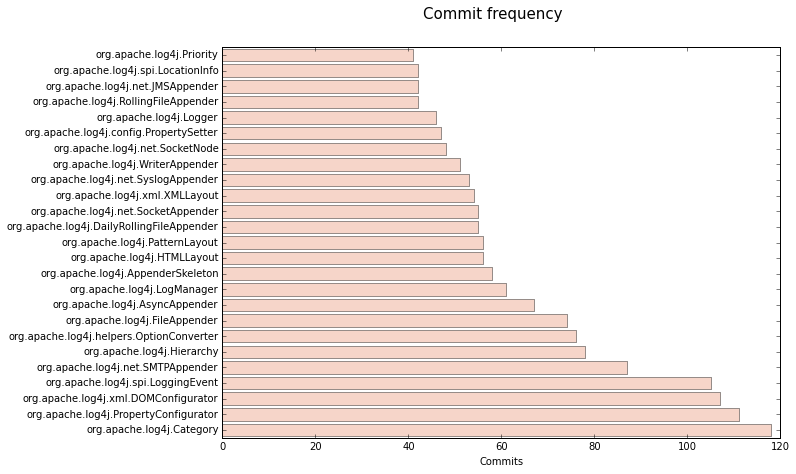

In [6]:
repo_url = 'https://github.com/' + USER + '/' + REPO
os.chdir(BASE_PATH)
os.system('git clone {}'.format(repo_url))

commit_dict = parse_git_log(BASE_PATH + REPO)
#print json.dumps(commit_dict, indent=4, sort_keys=True)
make_hbar_plot(commit_dict, 'Commit frequency', 'Commits', 25)

## Class reference count

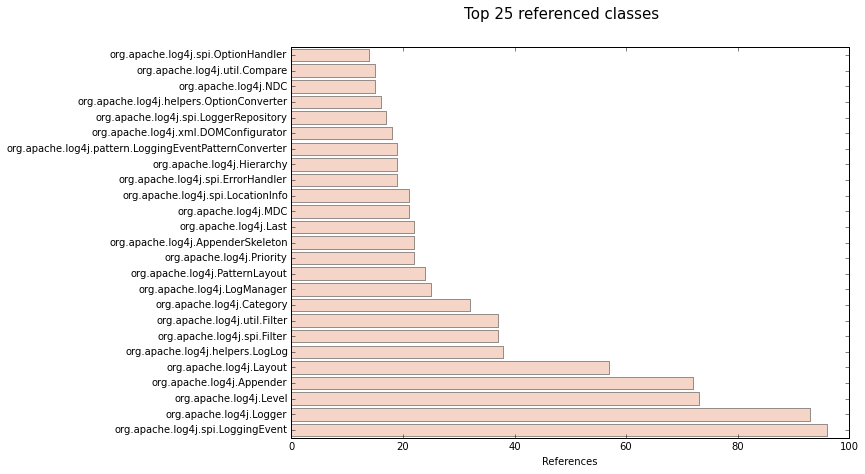

In [7]:
reference_dict = count_references(joined)
make_hbar_plot(reference_dict, 'Top 25 referenced classes', 'References', 25)

## Inheritance count

In [8]:
inheritance_count = count_inheritance(joined)
print inheritance_count

155


## Lines of code

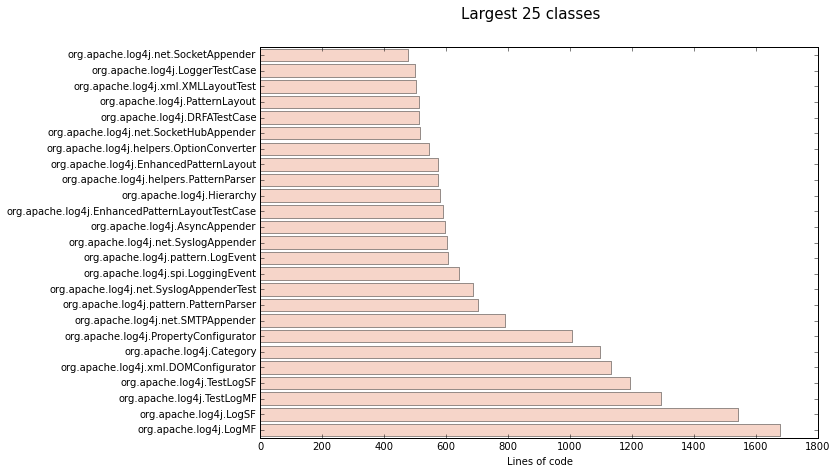

In [9]:
lines_dict = count_lines(joined)
make_hbar_plot(lines_dict, 'Largest 25 classes', 'Lines of code', 25)

## Number of methods

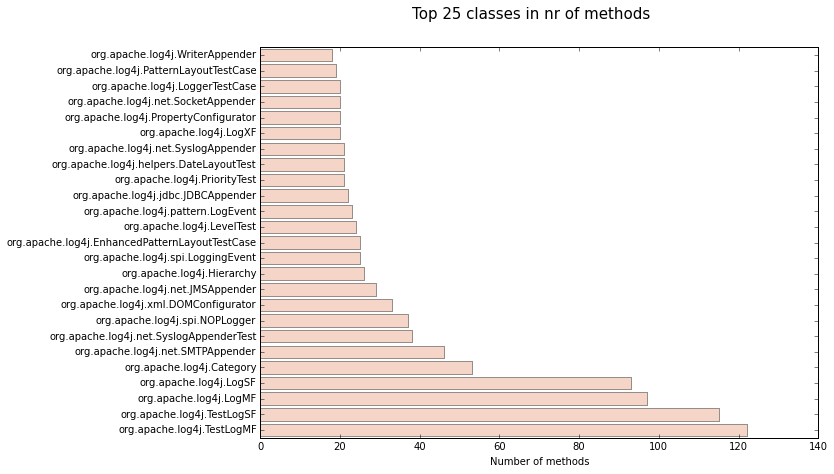

In [10]:
methods_dict = count_methods(joined)
make_hbar_plot(methods_dict, 'Top 25 classes in nr of methods', 'Number of methods', 25)

## Halstead complexity measures

To measure the Halstead complexity, following metrics are taken into account :
* the number of distinct operators (https://docs.oracle.com/javase/tutorial/java/nutsandbolts/opsummary.html)
* the number of distinct operands
* the total number of operators
* the total number of operands

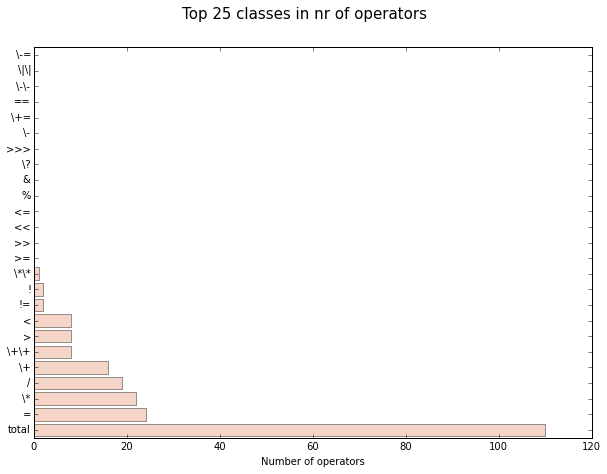

In [11]:
operators_dict = count_operators(joined)
make_hbar_plot(operators_dict, 'Top 25 classes in nr of operators', 'Number of operators', 25)

## Features

In [12]:
# Featurize all the above metrics

def make_features(name, lbl):
    features = []
    
    # Commit frequency
    features.append(int(commit_dict.get(name)))
    # Class reference count
    features.append(int(reference_dict.get(name)))
    # Lines of code
    features.append(int(lines_dict.get(name)))
    # Number of functions
    features.append(int(functions_dict.get(name)))
    
    return LabeledPoint(lbl, features)

In [13]:
# Utility function for evaluating the model precision

def eval_metrics(lbl_pred):
    tp = float(lbl_pred.filter(lambda lp: lp[0]==1.0 and lp[1]==1.0).count())
    tn = float(lbl_pred.filter(lambda lp: lp[0]==0.0 and lp[1]==0.0).count())
    fp = float(lbl_pred.filter(lambda lp: lp[0]==1.0 and lp[1]==0.0).count())
    fn = float(lbl_pred.filter(lambda lp: lp[0]==0.0 and lp[1]==1.0).count())
    
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    F_measure = 2 * precision * recall / (precision + recall)
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    
    return([tp, tn, fp, fn], [precision, recall, F_measure, accuracy])

In [14]:
features_list = []

names, tups = zip(*joined)
x = 0
for c in names:
    try:
        features_list.append(make_features(c, x))
        if x == 0:
            x = 1
        else:
            x = 0
    except:
        pass
    
#print features_list

In [15]:
# Make the linear SVM model

features_port = sc.parallelize(features_list)
train_port, test_port = features_port.randomSplit([0.7, 0.3], seed = 0)
labels = train_port.map(lambda lp: lp.label).collect()
features = train_port.map(lambda lp: lp.features).collect()

lin_clf = svm.LinearSVC()
lin_clf.fit(features, labels) 
labels_and_predictions = test_port.map(lambda lp: (lin_clf.predict(lp.features), lp.label))
metrics = eval_metrics(labels_and_predictions)

print('Precision : %.2f' % round(metrics[1][0], 2))
print('Recall : %.2f' % round(metrics[1][1], 2))
print('F1 : %.2f' % round(metrics[1][2], 2))
print('Accuracy : %.2f' % round(metrics[1][3], 2))

ValueError: Found array with 0 feature(s) (shape=(1, 0)) while a minimum of 1 is required.